## Time Sequence Prediction with LSTM

### What is LSTM and why it is useful?
LSTM stands for **Long Short-Term Memory (LSTM)** network, and is a variation of RNN discussed in another post. RNN is capable of learning order depedency in sequences, making it useful in applications such as time-series prediction, NLP, etc.

One key drawback for simple RNN is the **Vanishing / Exploding gradient problem**. RNN is not capable of remembering inputs from a certain amount of time before. According to the paper [Learning to Forget: Continual Prediction with LSTM](http://www.mitpressjournals.org/doi/abs/10.1162/089976600300015015) (Felix A. Gers, et al., 2000), RNN **fail to learn in the presence of time lags greater than 5 - 10 discrete time steps** between relevant input events and target signals. In short, RNN has a short-termm memory.

Long Short-Term Memory (LSTM) is an RNN architecture specifically designed to address the vanishing gradient problem. According to the paper [Learning to Forget: Continual Prediction with LSTM](http://www.mitpressjournals.org/doi/abs/10.1162/089976600300015015) (Felix A. Gers, et al., 2000), LSTM can learn to bridge minimal time lags in excess of 1000 discrete time steps by **enforcing constant error flow through “constant error carrousels” (CECs) within special units, called cells**.

---
### How does LSTM work?
The LSTM struture can be bast illustrated with the plot below.
<img src="pic/lstm.jpeg" width=500>

First let's talk about **C** on the top row.
**C** is often called **cell state**, and only simple linear transformations are performed to this parameter. Due to this scell state structure, LSTM can remember context several time steps in the past. This prevents **cell state** from the gradient vanishing/exploding problem on RNN. In short, **this cell state is what gives Long in LSTM**.

The addition or removal of information to cell state is controlled by gates, basically sigmoid layers. There are three kinds of gates in LSTM.

#### Forget Gate
The forget gate is expressed as $f_t$ in the previous image. The gate decides how much information we want to throw away from the previous cell state $h_{t-1}$. The equation for the forget gate can be expressed as:

$$f_t = \sigma(W_f * [h_{t-1},x_t] + b_f)$$

#### Input Gate
The inpu gate is set of sigmoid and tanh functino that add in new information we want to update / capture. The equations for the input gate can be expressed as:

$$i_t = \sigma(W_i * [h_{t-1},x_t] + b_i)$$
$$c_t' = tanh(W_C * [h_{t-1},x_t] + b_c)$$

With the help of forget gate and input gate, we can then update the cell state using the formula below.

$$c_t = f_t * c_{t-1} + i_t * c_t'$$

#### Output Gate

The output gate is where we product the information we want to output -- the $H_t$. It can be expressed with the following formula.

$$o_t = \sigma(W_o * [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t * tanh(c_t)$$


---
### Applications of LSTM

In this example, we are going to use LSTM to predict the sine wave for the future.

### Code Example

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [38]:
N = 100  # num of samples
L = 1000 # length of each sammple
T = 20   # width of wave

# create an empty array with all zeros
x = np.empty((N, L), np.float32) 

# shift each sample randommly for noise
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)

# corresponding sine value
y = np.sin(x/1.0/T).astype(np.float32)


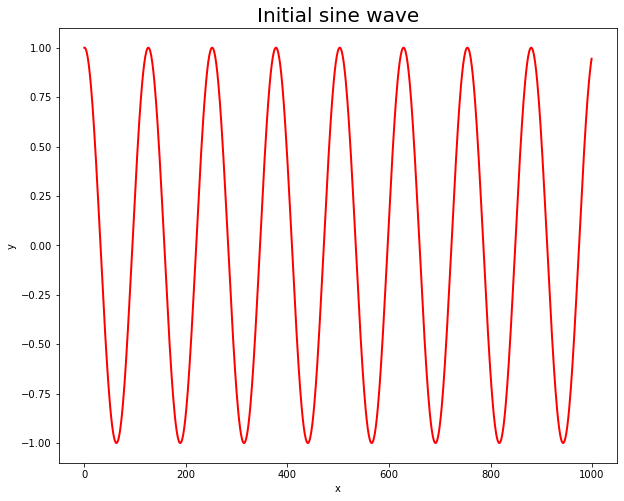

In [39]:
# plot out the initial data
plt.figure(figsize=(10,8))
plt.title("Initial sine wave", fontsize=20)
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(np.arange(x.shape[1]), y[0,:], 'r', linewidth=2.0)

In [40]:
## Create LSTM predictor, apply two lstm cells
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
    
    def forward(self, x, future=0):
        """
        Define the network feed forward steps.
        ----
        future: whether or not you want to make prediction during this training step. 
        If 0, no prediction is made --> simply the training step.
        """
        outputs = []
        n_smaples = x.size(0)
        
        # define initial hidden state and cell state for two lstm cell
        h_t = torch.zeros(n_smaples, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_smaples, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_smaples, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_smaples, self.n_hidden, dtype=torch.float32)        
        
        for input_t in x.split(1, dim=1): #torch.split -> split tensor into chunks 
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # If we want to do prediction concurrently
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t)) # the initial hidden state here is the output in the previous step
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [41]:
## Build training loop
# y = 100, 1000
train_input = torch.from_numpy(y[3:, :-1]) # previous position #97, 999
train_target = torch.from_numpy(y[3:, 1:]) # next position # 97, 999
test_input = torch.from_numpy(y[:3, :-1])  # 3, 999
test_target = torch.from_numpy(y[:3, 1:])  # 3, 999

model = LSTMPredictor(n_hidden=51)
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=.05) # Limited-memory BFGS
n_steps = 10

for i in range(n_steps):
    print("Step: ", i)
    
    def closure():
        """
        This closure function is needed for LBFGS optimizer.
        For more information check out the documentation for LBFGS.
        """
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        print("Loss: ", loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    with torch.no_grad():
        future = 1000
        pred = model(test_input, future=future) # now we make prediction on this
        loss = criterion(pred[:, :-future], test_target)
        print("Test loss: ", loss.item())
        y = pred.detach().numpy()
    
    # Make sure the plotting configuration is set
    plt.figure(figsize=(12,6))
    plt.title(f"Step {i+1}", fontsize=20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    n = train_input.shape[1] # 999
    
    def draw(y_i, color):
        plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0) # actual
        plt.plot(np.arange(n, n+future), y_i[n:], color + ':', linewidth=2.0) # prediction (in dashed style)
    
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('predict%d.pdf'%i)
    plt.close()

Step:  0
Loss:  0.5196808576583862
Loss:  0.5190184712409973
Loss:  0.5154992938041687
Loss:  0.5109149217605591
Loss:  0.5047890543937683
Loss:  0.49638035893440247
Loss:  0.48470038175582886
Loss:  0.4689958989620209
Loss:  0.4501206576824188
Loss:  0.4309552311897278
Loss:  0.41320371627807617
Loss:  0.3960367739200592
Loss:  0.37794819474220276
Loss:  0.3579604923725128
Loss:  0.3360850512981415
Loss:  0.31347817182540894
Loss:  0.2918410897254944
Loss:  0.272225022315979
Loss:  0.2546114921569824
Loss:  0.23845598101615906
Test loss:  0.22415518760681152
Step:  1
Loss:  0.22318270802497864
Loss:  0.20830343663692474
Loss:  0.19341017305850983
Loss:  0.1782105714082718
Loss:  0.16265371441841125
Loss:  0.14706353843212128
Loss:  0.13204175233840942
Loss:  0.11813244968652725
Loss:  0.10561802983283997
Loss:  0.09456376731395721
Loss:  0.08491635322570801
Loss:  0.07655983418226242
Loss:  0.06934908032417297
Loss:  0.06313341110944748
Loss:  0.0577709935605526
Loss:  0.0531350187957

### After LSTM: Transformers
Transformers were introducted in the context of machine translation in order to allow parallel computation and redue drop in performances due to long dependencies. Key charateristics of tranformers are:

1. **Non Sequencial**
2. **Self Attention**

3. **Positional Embedding**

For more detail about LSTM, please refer to my later learning notes.


### Notes & Takeaways

* In general, there are no guidelines on how to determine the number of layers or the number of memory cells in an LSTM. Empirically we do see that the more layers we have, the higher accuracy the model can perform but the slower the training speed. [[reference]](https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm)



* In PyTorch, there are two implementations relate to LSTM.
    * `LSTMCell`: a cell of LSTM structure. [reference](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html#torch.nn.LSTMCell)
    * `LSTM`: a comprehensive layer for the application of LSTM cells. This layer includes numerous tricks such as drop-out. [reference](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)
    
    
* The `LSTM` layer provides three outputs: output, h_n, c_n. [reference](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm)
    * `h_n, c_n`: comprises the hidden states after the last timestamp.
    * `output`: comprises all the hideen states in the last layer.



### Reference

[PyTorch Time Sequence Prediction With LSTM - Forecasting Tutorial](https://www.youtube.com/watch?v=AvKSPZ7oyVg&ab_channel=PythonEngineer)

[A Gentle Introduction to Long Short-Term Memory Networks by the Experts](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/)

[A 7 Minute Introduction to LSTM by Prateek Karkare](https://medium.com/x8-the-ai-community/a-7-minute-introduction-to-lstm-5e1480e6f52a)